In [2]:
import numpy as np
import pandas as pd
from astropy.io import fits
import datetime 
import matplotlib.pyplot as plt

from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import os
import sys
sys.path.append('../radiospectra2')

from radiospectra.sources import CallistoSpectrogram
from matplotlib.axis import Axis  
from matplotlib.ticker import MaxNLocator, IndexLocator
from scipy import interpolate
from copy import deepcopy
import matplotlib.ticker as ticker
from matplotlib.dates import MinuteLocator
# #import julian

/home/delberin/eCallistoValidation/validation/Orfees/../radiospectra2/radiospectra/version.py:12: UserWarning: could not determine radiospectra package version; this indicates a broken installation
  warnings.warn(


In [3]:
# final Version

class OrfeesSpectrogram():
    
    def __init__(self, file=None,  t_label="Time",  f_label="Frequency"):
        data = {}
        
        if file:
            data = self.read_orfees(file)
               
        self.__init_values__(**data)
            
    def __init_values__(self, **kwargs):
        self.data = kwargs.get("data", None)
        self.time_axis = kwargs.get("time_axis", None)
        self.freq_axis = kwargs.get("freq_axis", None)
        self.date_obs = kwargs.get("date_obs", None)
        self.time_start_obs = kwargs.get("time_start_obs", None)
        self.time_end_obs = kwargs.get("time_end_obs", None)

        self.t_label = kwargs.get("t_label", None)
        self.f_label = kwargs.get("f_label", None)
  

    def read_orfees(self, filename):
        hdulist=fits.open(filename)

        h_file = hdulist[0].header   # Header file
        frequency = hdulist[1].data  # data Extend1 (ferquency)
        h_data = hdulist[2].data     # data Extend2 (data)


        date_obs = h_file[4]         # Date observation start
        time_start_obs = h_file[5]   # Time observation start
        time_end_obs = h_file[7]     # Date observation End
      

        # STOKESI_B: nata for Stokes parameter I (STOKESI) per bann
        data_SI_B1 = h_data.STOKESI_B1
        data_SI_B2 = h_data.STOKESI_B2
        data_SI_B3 = h_data.STOKESI_B3
        data_SI_B4 = h_data.STOKESI_B4
        data_SI_B5 = h_data.STOKESI_B5

        # TIME_B: Time in seconn per band
        time_1 = h_data.TIME_B1
        time_2 = h_data.TIME_B2
        time_3 = h_data.TIME_B3
        time_4 = h_data.TIME_B4
        time_5 = h_data.TIME_B5

        # The Frequency 
        freq_b1=frequency.FREQ_B1[0]
        freq_b2=frequency.FREQ_B2[0]
        freq_b3=frequency.FREQ_B3[0]
        freq_b4=frequency.FREQ_B4[0]
        freq_b5=frequency.FREQ_B5[0]
        
        # concatenate all together using np.concatenate
        time_axis = np.concatenate([time_1, time_2, time_3, time_4, time_5])
        freq_axis = np.concatenate([freq_b1,freq_b2,freq_b3,freq_b4,freq_b5])
        data = np.concatenate([data_SI_B1,data_SI_B2,data_SI_B3,data_SI_B4,data_SI_B5],axis=1)

        return {
            "data": data,  #[:, 240:370],
            "time_axis": time_axis,
            "freq_axis": freq_axis,
            "date_obs": date_obs,
            "time_start_obs": time_start_obs,
            "time_end_obs": time_end_obs
        }
    
    
    def convert_ms_to_date(self):
        # this function get the time axis from orfees file as miliseconds and convert it to date, return a list.(12:00:04.932000)
        times = self.time_axis
        
        list_of_times= []
        for time in times:
            delta = datetime.timedelta(0, 0, 0, int(time))
            list_of_times.append(str(delta).split(".")[0])

        return list_of_times
    


    def peek(self):

        fig, ax = plt.subplots()
        dates = self.convert_ms_to_date()

        ax.xaxis.set_major_locator(MaxNLocator(prune='both', nbins=6))
        ax.set_xticklabels(dates[::int(len(dates)//30 )], rotation = 50, horizontalalignment="right")
      
        # plt.yticks(np.linspace(self.freq_axis.min(),self.freq_axis.max(), 15 )) #15

        xmin = min(self.time_axis)
        xmax = max(self.time_axis)
        ymin = min(self.freq_axis)
        ymax = max(self.freq_axis)

        # spec = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2015/11/04/HB9SCT_20151104_120000_59.fit.gz')

        # resized_data = self.resize_array(self.data, spec.shape[1],spec.shape[0])
        plt.imshow(self.data.transpose(), vmin = self.data.min(), origin='lower',vmax = 1000,aspect="auto", extent=[xmin, xmax, ymin, ymax])   # [:, 240:370]
        # plt.yticks(np.arange(self.freq_axis.min(),self.freq_axis.max(), 50))
       
        
        plt.colorbar()

        plt.gca().set_ylim(ymax, ymin)
        
        plt.title(f"ORFEES, {self.date_obs}")
        plt.xlabel('Time[UT]')
        plt.ylabel('Frequency [MHz]')

        plt.show()

12:14:59:880
(90, 998)
144.13
1004.7


/tmp/ipykernel_1636/3716192548.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates[::int(len(dates)//30 )], rotation = 50, horizontalalignment="right")


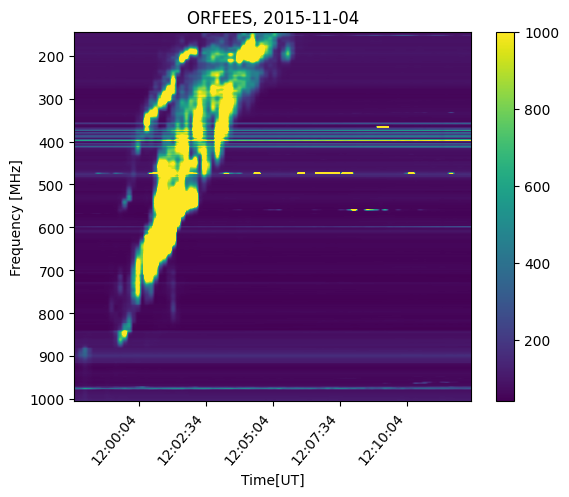

In [3]:
orfees = OrfeesSpectrogram("./orfees_files/int_orf20151104_120000_10.fts")
start = orfees.time_end_obs
print(start)
print(orfees.data.shape)
print(orfees.freq_axis.min())
print(orfees.freq_axis.max())
orfees.peek()
plt.show()

<AxesSubplot: xlabel='Time [UT]', ylabel='Frequency [MHz]'>

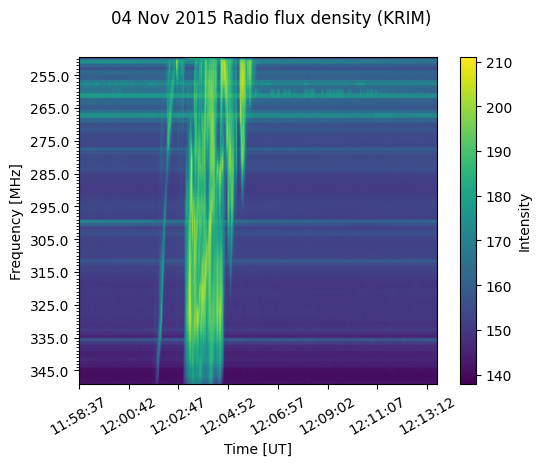

In [4]:
spec3 = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2015/11/04/KRIM_20151104_115837_00.fit.gz')
spec3.plot()

Shape after: (200, 3600)


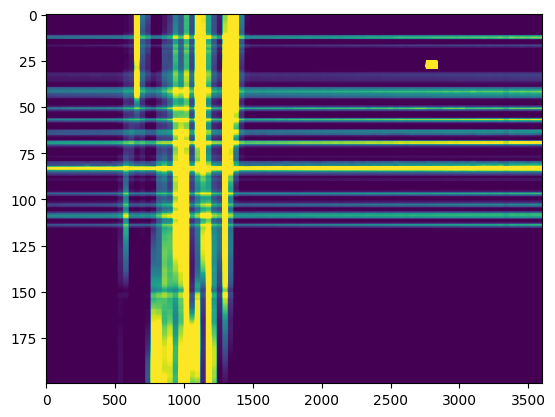

In [34]:
orfees_test = OrfeesSpectrogram("./orfees_files/int_orf20151104_120000_10.fts")
array = orfees_test.data[:, 240:370]

# https://stackoverflow.com/questions/8090229/resize-with-averaging-or-rebin-a-numpy-2d-array
def resize_array(a, new_rows, new_cols): 
    '''
    This function takes an 2D numpy array a and produces a array 
    of size new_rows, new_cols. 
    '''
    rows = len(a)
    cols = len(a[0])
    yscale = float(rows) / new_rows 
    xscale = float(cols) / new_cols

    # first average across the cols to shorten rows    
    new_a = np.zeros((rows, new_cols)) 
    for j in range(new_cols):

        # get the indices of the original array we are going to average across
        the_x_range = (j*xscale, (j+1)*xscale)
        firstx = int(the_x_range[0])
        lastx = int(the_x_range[1])

        # figure out the portion of the first and last index that overlap with the new index, and thus the portion of those cells that we need to include in our average
        x0_scale = 1 - (the_x_range[0]-int(the_x_range[0]))
        xEnd_scale =  (the_x_range[1]-int(the_x_range[1]))

        # scale_line is a 1d array that corresponds to the portion of each old index in the_x_range that should be included in the new average
        scale_line = np.ones((lastx-firstx+1))
        scale_line[0] = x0_scale
        scale_line[-1] = xEnd_scale
        # Make sure you don't screw up and include an index that is too large for the array. This isn't great, as there could be some floating point errors that mess up this comparison.
        if scale_line[-1] == 0:
            scale_line = scale_line[:-1]
            lastx = lastx - 1
            
        # Now it's linear algebra time. Take the dot product of a slice of the original array and the scale_line
        new_a[:,j] = np.dot(a[:,firstx:lastx+1], scale_line)/scale_line.sum()

    # Then average across the rows to shorten the cols. Same method as above. It is probably possible to simplify this code, as this is more or less the same procedure as the block of code above, but transposed. Here I'm reusing the variable a. Sorry if that's confusing.
    a = np.zeros((new_rows, new_cols))
    for i in range(new_rows):
        the_y_range = (i*yscale, (i+1)*yscale)
        firsty = int(the_y_range[0])
        lasty = int(the_y_range[1])
        y0_scale = 1 - (the_y_range[0]-int(the_y_range[0]))
        yEnd_scale =  (the_y_range[1]-int(the_y_range[1]))
        scale_line = np.ones((lasty-firsty+1))
        scale_line[0] = y0_scale
        scale_line[-1] = yEnd_scale
        if scale_line[-1] == 0:
            scale_line = scale_line[:-1]
            lasty = lasty - 1
        a[i:,] = np.dot(scale_line, new_a[firsty:lasty+1,])/scale_line.sum() 

    return a.transpose() 


spec = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2015/11/04/HB9SCT_20151104_120000_59.fit.gz')

# taking the shape of the ecallisto spec:
with_resize  = resize_array(array, spec.shape[1],spec.shape[0])
print(f"Shape after: {with_resize.shape}")

plt.imshow(with_resize,vmin=100, vmax=1000, aspect="auto")

this is with resize function :59.156990638145935
this is with resize function :167847.62500000003


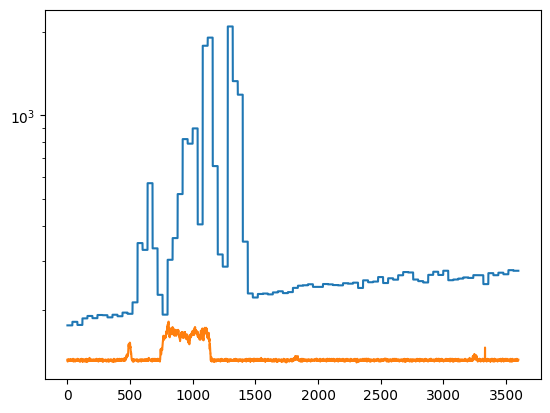

In [11]:
print(f"this is with resize function :{with_resize.min()}")
print(f"this is with resize function :{with_resize.max()}")


# plt.plot(with_resize)
plt.plot(with_resize[50])
plt.plot(spec.data[50])
plt.yscale("log")
plt.show()

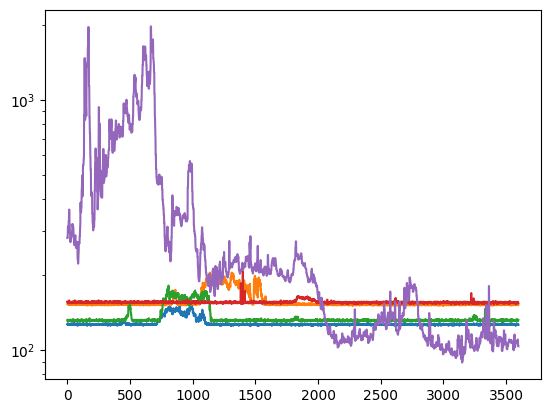

In [32]:
spec2 = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2015/11/04/BIR_20151104_120000_03.fit.gz')
spec3 = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2015/11/04/KRIM_20151104_115837_00.fit.gz')
spec4 = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2015/11/04/HB9SCT_20151104_120000_59.fit.gz')
spec5 = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2015/11/04/GLASGOW_20151104_120000_59.fit.gz')

plt.plot(spec2.data[50])
plt.plot(spec3.data[50])
plt.plot(spec4.data[50])
plt.plot(spec5.data[50])
plt.plot(with_resize[50])
plt.yscale("log")
plt.show()


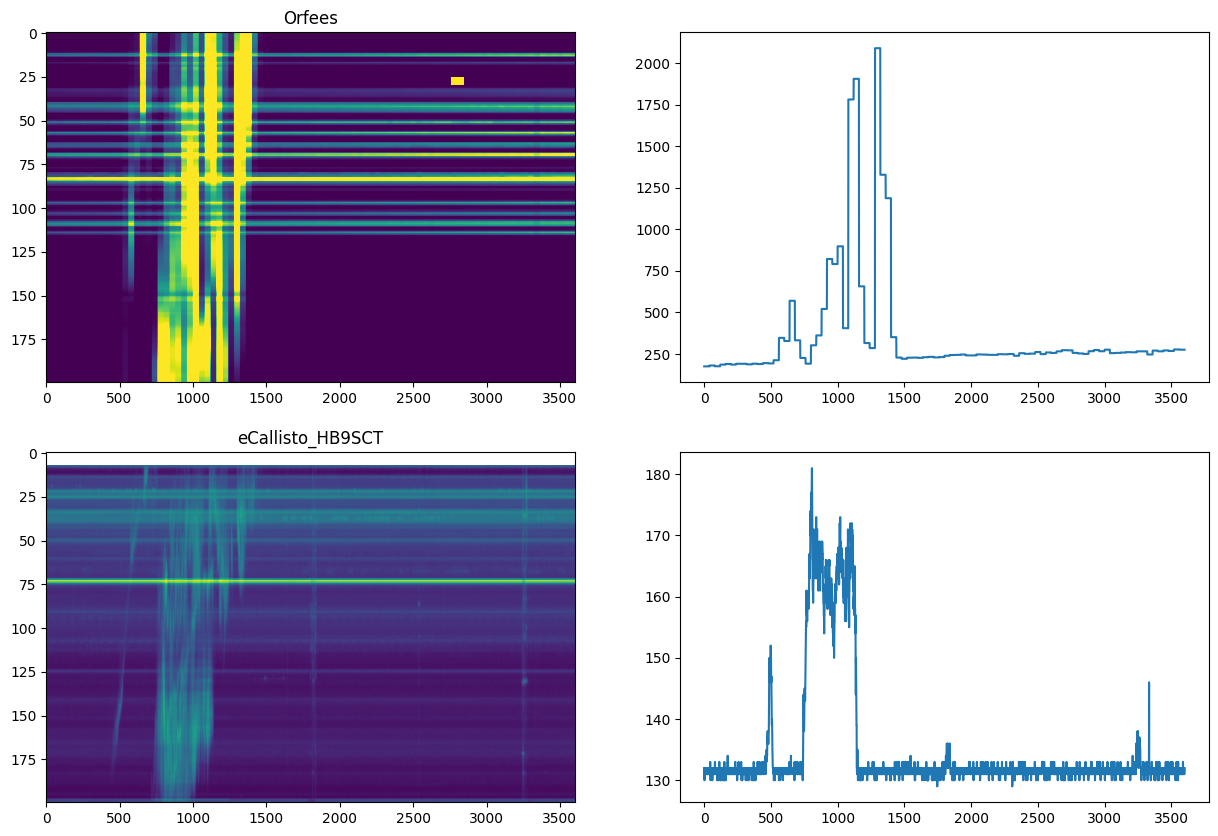

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].imshow(with_resize,vmin=100, vmax=1000, aspect="auto")
axs[0, 0].set_title("Orfees")
axs[1, 0].imshow(spec4.data[::-1], aspect="auto")
axs[1, 0].set_title("eCallisto_HB9SCT")
axs[0, 1].plot(with_resize[50])
axs[1, 1].plot(spec4.data[50])

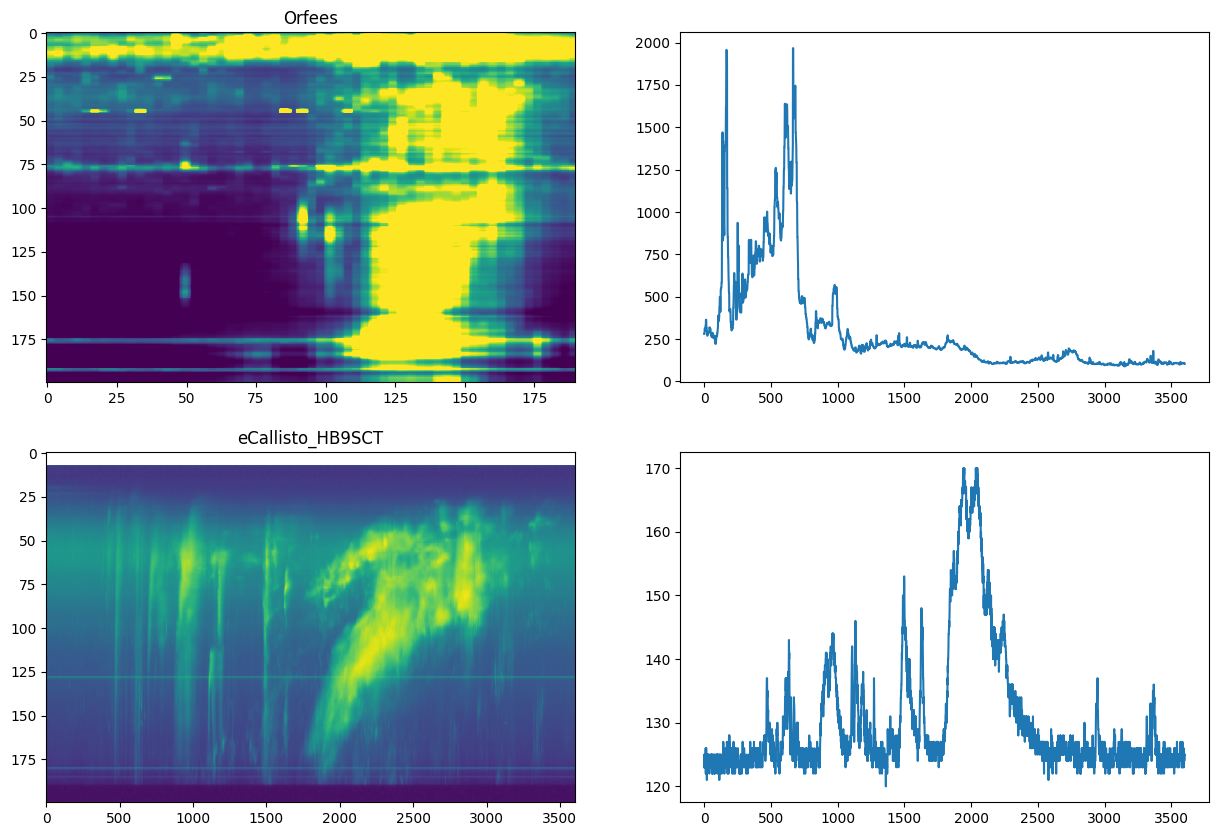

In [38]:
test_2 = OrfeesSpectrogram("./orfees_files/int_orf20170906_115500_10.fts")

_data = test_2.data

spec = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2017/09/06/GREENLAND_20170906_115514_62.fit.gz')

# # taking the shape of the ecallisto spec:
_resize  = resize_array(_data, spec.shape[1],spec.shape[0])
# print(f"Shape after: {_resize.shape}")

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].imshow(_resize[:, 10:200],vmin=100, vmax=1000, aspect="auto")
axs[0, 0].set_title("Orfees")
axs[1, 0].imshow(spec.data[::-1], aspect="auto")
axs[1, 0].set_title("eCallisto_HB9SCT")
axs[0, 1].plot(_resize[50])
axs[1, 1].plot(spec.data[50])